In [54]:
from keras.models import load_model
from data_generator import AudioGenerator
import pickle as pickle

from keras import backend as K
from keras.models import Model
from keras.layers import (Input, Lambda)
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint   
import os

In [1]:
from keras.layers import CuDNNGRU
from keras.layers import Bidirectional
from keras.layers import CuDNNLSTM, TimeDistributed, Dropout
from keras import Sequential
from data_generator import vis_train_features
from IPython.display import Markdown, display
from data_generator import vis_train_features, plot_raw_audio
from IPython.display import Audio
%matplotlib inline

Using TensorFlow backend.


There are 2136 total training examples.


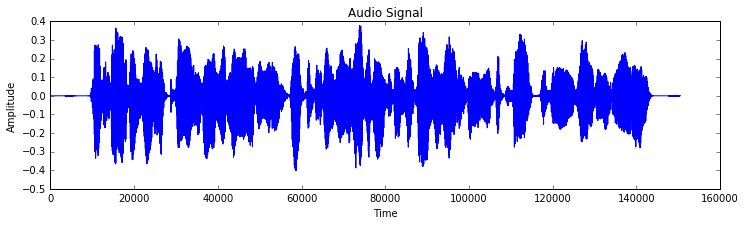

**Shape of Audio Signal** : (150381,)

**Transcript** : outside of these occasional reminders we could see no evidence of the desolation of the track of an invading army

In [2]:
# extract label and audio features for a single training example
vis_text, vis_raw_audio, vis_mfcc_feature, vis_spectrogram_feature, vis_audio_path = vis_train_features(index=3)
# plot audio signal
plot_raw_audio(vis_raw_audio)
# print length of audio signal
display(Markdown('**Shape of Audio Signal** : ' + str(vis_raw_audio.shape)))
# print transcript corresponding to audio clip
display(Markdown('**Transcript** : ' + str(vis_text)))
# play the audio file
Audio(vis_audio_path)

In [3]:
#####################################################################
# RUN THIS CODE CELL IF YOU ARE RESUMING THE NOTEBOOK AFTER A BREAK #
#####################################################################

# allocate 50% of GPU memory (if you like, feel free to change this)
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf 
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.95
set_session(tf.Session(config=config))

# watch for any changes in the sample_models module, and reload it automatically
%load_ext autoreload
%autoreload 2
# import NN architectures for speech recognition
#from sample_models
# import function for training acoustic model

from keras.models import load_model
from keras import backend as K
from keras.models import Model
from keras.layers import (BatchNormalization, Conv1D, Dense, Input, Conv2D, 
    TimeDistributed, Activation, Bidirectional, SimpleRNN, GRU, LSTM)

In [4]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16435098371145574795
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 530841600
locality {
  bus_id: 1
}
incarnation: 7358197943543520607
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:03:00.0"
]


In [24]:
from keras.layers import MaxPool1D, MaxPooling1D

In [5]:
from continue_train import train_model

In [44]:
def cnn_rnn_model(input_dim, filters, kernel_size, conv_stride,
    conv_border_mode, units, output_dim=29):
    """ Build a recurrent + convolutional network for speech 
    """
    # Main acoustic input
    input_data = Input(name='the_input', shape=(None, input_dim))
    
    # Add convolutional layer
    conv_1d = Conv1D(filters, kernel_size, 
                     strides=conv_stride, 
                     padding=conv_border_mode,
                     activation='relu',
                     name='conv1d')(input_data)
    max_pooling = MaxPooling1D()(conv_1d)
    conv_2d = Conv1D(64, 8, 
                     strides=conv_stride, 
                     padding=conv_border_mode,
                     activation='relu',
                     name='conv2d')(max_pooling)
    
    bn_cnn = BatchNormalization(name='bn_conv_1d')(conv_2d)
    # Add a recurrent layer
    layer1 = Bidirectional(CuDNNLSTM(units=units,return_sequences=True), merge_mode='concat')(bn_cnn)
    drop1 = Dropout(0.7)(layer1)
    bn_rnn1 =BatchNormalization()(drop1)
    #drop1 = Dropout(0.7)(bn_rnn1)
    layer2 = Bidirectional(CuDNNLSTM(units=units, return_sequences= True), merge_mode='concat')(bn_rnn1)
    drop2 = Dropout(0.7)(layer2)
    bn_rnn2 =BatchNormalization()(drop2)
    #drop2 = Dropout(0.7)(bn_rnn2)
    layer3 = Bidirectional(CuDNNLSTM(units=units, return_sequences= True), merge_mode='concat')(bn_rnn2)
    drop3 = Dropout(0.7)(layer3)
    bn_rnn3 =BatchNormalization()(drop3)
    layer4 = Bidirectional(CuDNNLSTM(units=units, return_sequences= True), merge_mode='concat')(bn_rnn3)
    drop4 = Dropout(0.7)(layer4)
    bn_rnn4 =BatchNormalization()(drop4)
    layer5 = Bidirectional(CuDNNLSTM(units=units, return_sequences= True), merge_mode='concat')(bn_rnn4)
    drop5 = Dropout(0.7)(layer5)
    bn_rnn5 =BatchNormalization()(drop5)
    layer6 = Bidirectional(CuDNNLSTM(units=units, return_sequences= True), merge_mode='concat')(bn_rnn5)
    drop6 = Dropout(0.7)(layer6)
    bn_rnn6 =BatchNormalization()(drop6)
    layer7 = Bidirectional(CuDNNLSTM(units=units, return_sequences= True), merge_mode='concat')(bn_rnn6)
    drop7 = Dropout(0.7)(layer7)
    bn_rnn7 =BatchNormalization()(drop7)
    
    # TODO: Add a TimeDistributed(Dense(output_dim)) layer
    time_dense = TimeDistributed(Dense(output_dim))(bn_rnn7)
    # Add softmax activation layer
    y_pred = Activation('softmax', name='softmax')(time_dense)
    # Specify the model
    model = Model(inputs=input_data, outputs=y_pred)
    #model.output_length = lambda x: x
    if conv_border_mode == 'same':
        model.output_length = lambda x: (x + 2*conv_stride - 1)// (2*conv_stride)
    else:
        dilated_filter_size = kernel_size + (kernel_size - 1) * (conv_stride - 1)
        model.output_length = lambda x: x  - dilated_filter_size + 1
       
    print(model.summary())
    return model

In [41]:
def cnn_output_length(input_length, filter_size, border_mode, stride,
                       dilation=1):
    """ Compute the length of the output sequence after 1D convolution along
        time. Note that this function is in line with the function used in
        Convolution1D class from Keras.
    Params:
        input_length (int): Length of the input sequence.
        filter_size (int): Width of the convolution kernel.
        border_mode (str): Only support `same` or `valid`.
        stride (int): Stride size used in 1D convolution.
        dilation (int)
    """
    if input_length is None:
        return None
    assert border_mode in {'same', 'valid'}
    dilated_filter_size = filter_size + (filter_size - 1) * (dilation - 1)
    if border_mode == 'same':
        output_length = input_length
    elif border_mode == 'valid':
        output_length = input_length - dilated_filter_size + 1
    return (output_length + stride - 1) // stride

In [45]:
model_7 = cnn_rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                        filters=128,
                        kernel_size=16, 
                        conv_stride=2,
                        conv_border_mode='same',
                        units=512)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 128)         329856    
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, None, 128)         0         
_________________________________________________________________
conv2d (Conv1D)              (None, None, 64)          65600     
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 64)          256       
_________________________________________________________________
bidirectional_52 (Bidirectio (None, None, 1024)        2367488   
_________________________________________________________________
dropout_50 (Dropout)         (None, None, 1024)        0         
__________

In [52]:

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

def add_ctc_loss(input_to_softmax):
    the_labels = Input(name='the_labels', shape=(None,), dtype='float32')
    input_lengths = Input(name='input_length', shape=(1,), dtype='int64')
    label_lengths = Input(name='label_length', shape=(1,), dtype='int64')
    output_lengths = Lambda(input_to_softmax.output_length)(input_lengths)
    # CTC loss is implemented in a lambda layer
    loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')(
        [input_to_softmax.output, the_labels, output_lengths, label_lengths])
    model = Model(
        inputs=[input_to_softmax.input, the_labels, input_lengths, label_lengths], 
        outputs=loss_out)
    return model

def cnn_output_length(input_length, filter_size, border_mode, stride,
                       dilation=1):
    """ Compute the length of the output sequence after 1D convolution along
        time. Note that this function is in line with the function used in
        Convolution1D class from Keras.
    Params:
        input_length (int): Length of the input sequence.
        filter_size (int): Width of the convolution kernel.
        border_mode (str): Only support `same` or `valid`.
        stride (int): Stride size used in 1D convolution.
        dilation (int)
    """
    if input_length is None:
        return None
    assert border_mode in {'same', 'valid'}
    dilated_filter_size = filter_size + (filter_size - 1) * (dilation - 1)
    if border_mode == 'same':
        output_length = input_length
    elif border_mode == 'valid':
        output_length = input_length - dilated_filter_size + 1
    return (output_length + stride - 1) // stride

In [56]:
def train_model(input_to_softmax, 
                pickle_path,
                save_model_path,
                load_model_path,
                train_json='train_corpus.json',
                valid_json='valid_corpus.json',
                minibatch_size=20,
                spectrogram=True,
                mfcc_dim=13,
                optimizer=SGD(lr=0.002, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5),
                epochs=20,
                verbose=1,
                continue_training=True,
                sort_by_duration=False,
                max_duration=10.0):
    
    # create a class instance for obtaining batches of data
    audio_gen = AudioGenerator(minibatch_size=minibatch_size, 
        spectrogram=spectrogram, mfcc_dim=mfcc_dim, max_duration=max_duration,
        sort_by_duration=sort_by_duration)
    # add the training data to the generator
    audio_gen.load_train_data(train_json)
    audio_gen.load_validation_data(valid_json)
    # calculate steps_per_epoch
    num_train_examples=len(audio_gen.train_audio_paths)
    steps_per_epoch = num_train_examples//minibatch_size
    # calculate validation_steps
    num_valid_samples = len(audio_gen.valid_audio_paths) 
    validation_steps = num_valid_samples//minibatch_size
    
    # add CTC loss to the NN specified in input_to_softmax
    model = add_ctc_loss(input_to_softmax)
    if continue_training:
        model = load_model('results/' + load_model_path, custom_objects={'<lambda>': lambda y_true, y_pred: y_pred} )
        #model = load_model('results/' + save_model_path)
    # CTC loss is implemented elsewhere, so use a dummy lambda function for the loss
    model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)

    # make results/ directory, if necessary
    if not os.path.exists('results'):
        os.makedirs('results')

    # add checkpointer
    checkpointer = ModelCheckpoint(filepath='results/'+save_model_path, verbose=0)

    # train the model
    print(steps_per_epoch)
    hist = model.fit_generator(generator=audio_gen.next_train(), steps_per_epoch=steps_per_epoch+500,
        epochs=epochs, validation_data=audio_gen.next_valid(), validation_steps=validation_steps,
        callbacks=[checkpointer], verbose=verbose)

    # save model loss
    with open('results/'+pickle_path, 'wb') as f:
        pickle.dump(hist.history, f)
    return hist

In [61]:
model_7.output_length.

{}

In [57]:
hist = train_model(input_to_softmax=model_7, 
            pickle_path='model_7.pickle', 
            save_model_path='model_7.h5', minibatch_size=10,
            load_model_path='model_7.h5',
            train_json = 'train_more.json',
            epochs = 1,
            continue_training=False,
            spectrogram=True) # change to False if you would like to use MFCC features

3830
Epoch 1/1


InvalidArgumentError: label SparseTensor is not valid: indices[124] = [0,124] is out of bounds: need 0 <= index < [10,124]
	 [[Node: ctc_9/CTCLoss = CTCLoss[ctc_merge_repeated=true, ignore_longer_outputs_than_inputs=false, preprocess_collapse_repeated=false, _device="/job:localhost/replica:0/task:0/cpu:0"](ctc_9/Log/_6405, ctc_9/ToInt64/_6407, ctc_9/ToInt32_2/_6409, ctc_9/ToInt32_1/_6411)]]

Caused by op u'ctc_9/CTCLoss', defined at:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python2.7/dist-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2718, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2822, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-57-b7315b7ad5a7>", line 8, in <module>
    spectrogram=True) # change to False if you would like to use MFCC features
  File "<ipython-input-56-47523198b129>", line 32, in train_model
    model = add_ctc_loss(input_to_softmax)
  File "<ipython-input-52-d567a3560900>", line 13, in add_ctc_loss
    [input_to_softmax.output, the_labels, output_lengths, label_lengths])
  File "/usr/local/lib/python2.7/dist-packages/keras/engine/topology.py", line 603, in __call__
    output = self.call(inputs, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/keras/layers/core.py", line 651, in call
    return self.function(inputs, **arguments)
  File "<ipython-input-52-d567a3560900>", line 4, in ctc_lambda_func
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
  File "/usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py", line 3755, in ctc_batch_cost
    sequence_length=input_length), 1)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/ctc_ops.py", line 152, in ctc_loss
    ignore_longer_outputs_than_inputs=ignore_longer_outputs_than_inputs)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/gen_ctc_ops.py", line 170, in _ctc_loss
    name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): label SparseTensor is not valid: indices[124] = [0,124] is out of bounds: need 0 <= index < [10,124]
	 [[Node: ctc_9/CTCLoss = CTCLoss[ctc_merge_repeated=true, ignore_longer_outputs_than_inputs=false, preprocess_collapse_repeated=false, _device="/job:localhost/replica:0/task:0/cpu:0"](ctc_9/Log/_6405, ctc_9/ToInt64/_6407, ctc_9/ToInt32_2/_6409, ctc_9/ToInt32_1/_6411)]]


In [ ]:
    # Add batch normalization
    conv_2d = Conv1D(64, 8, 
                     strides=conv_stride, 
                     padding=conv_border_mode,
                     activation='relu',
                     name='conv2d')(conv_1d)
    conv_3d = Conv1D(32, 4, 
                     strides=conv_stride, 
                     padding=conv_border_mode,
                     activation='relu',
                     name='conv3d')(conv_2d)
 